# 3D render software
This is the software part of project. We use PYNQ to control 3D render ip.

First we need read obj file which store the 3d information. We have two example called "cube.obj" and "space_ship.obj". Using other obj files is also right. But it requires that the number of points does not exceed 110 and the number of faces does not exceed 110.

In [92]:
import numpy as np
with open("space_ship.obj") as file:
    point = []
    face = []
    while 1:
        line = file.readline()
        if not line:
            break
        strs = line.split(" ")
        if strs[0] == "v":
            point.append([float(strs[1]), float(strs[2]), float(strs[3])])
        if strs[0] == "f":
            face.append([int(strs[1]), int(strs[2]), int(strs[3])])
print(point)
print(face)

[[1.0, -1.0, -1.0], [1.0, 1.0, -1.0], [1.0, -1.0, 1.0], [1.0, 1.0, 1.0], [-1.0, -1.0, -1.0], [-1.0, 1.0, -1.0], [-1.0, -1.0, 1.0], [-1.0, 1.0, 1.0], [-0.72, 0.12, -1.4], [0.3, 0.0, 5.0], [-0.6, -0.6, -1.4], [-0.3, 0.0, 5.0], [-1.2, 0.2, 1.0], [-0.6, 0.6, -1.4], [-1.2, -0.2, -1.0], [-1.2, 0.2, -1.0], [1.2, -0.2, 1.0], [1.2, -0.2, -1.0], [1.2, 0.2, -1.0], [1.2, 0.2, 1.0], [-1.2, -0.2, 1.0], [0.6, 0.6, -1.4], [0.6, -0.6, -1.4], [-4.2, 0.06, 1.0], [-4.2, -0.06, 1.0], [-4.2, -0.06, -1.0], [-4.2, 0.06, -1.0], [4.2, -0.06, 1.0], [4.2, -0.06, -1.0], [4.2, 0.06, -1.0], [4.2, 0.06, 1.0], [4.2, -0.18, 1.0], [4.2, -0.18, -1.0], [4.2, 0.18, -1.0], [4.2, 0.18, 1.0], [4.5, -0.18, 1.0], [4.5, -0.18, -1.0], [4.5, 0.18, -1.0], [4.5, 0.18, 1.0], [-4.2, 0.18, 1.0], [-4.2, -0.18, 1.0], [-4.2, -0.18, -1.0], [-4.2, 0.18, -1.0], [-4.5, 0.18, 1.0], [-4.5, -0.18, 1.0], [-4.5, -0.18, -1.0], [-4.5, 0.18, -1.0], [4.35, -0.18, 3.0], [4.35, 0.18, 3.0], [-4.35, 0.18, 3.0], [-4.35, -0.18, 3.0], [0.0, -0.7, 3.0], [-0.7

We need configure some basic data such as the angle at which the object is viewed( rotation_x_theta, rotation_y_theta, rotation_z_theta), the viewing distance from the object( distance). We recommend that: 10 <= screen_height / screen_width <= 100, 0 <= rotation_x_theta / rotation_y_theta / rotation_z_theta <= 360, 2 <= distance <= 10. Values that are too extreme may cause unknown errors. Please avoid this.

In [93]:
triangle_number_max = 110
screen_height_max = 100
screen_width_max = 100
triangle_number = np.uint8(len(face))
screen_height = np.uint8(100)
screen_width = np.uint8(100)
rotation_x_theta = np.float32(200)
rotation_y_theta = np.float32(20)
rotation_z_theta = np.float32(10)
distance = np.float32(7)
mesh_transmission = np.zeros((triangle_number_max*3*3), dtype=np.float32)
for i in range(triangle_number):
    for j in range(3):
        for k in range(3):
            mesh_transmission[i*9+j*3+k] = point[face[i][j]-1][k]
print(mesh_transmission)


[-1.2  -0.2   1.    0.   -0.7   3.   -0.3   0.    5.   -1.    1.   -1.
 -1.2   0.2   1.   -1.    1.    1.   -1.   -1.   -1.    0.6  -0.6  -1.4
  1.   -1.   -1.   -1.   -1.    1.    1.   -1.   -1.    1.   -1.    1.
  1.    1.    1.   -1.    1.   -1.   -1.    1.    1.    1.    1.    1.
 -0.3   0.    5.    0.3   0.    5.    1.2  -0.2   1.    1.2   0.2   1.
  0.3   0.    5.    1.2   0.2   1.    1.    1.    1.    0.3   0.    5.
  1.2  -0.2   1.    0.   -0.7   3.    1.   -1.    1.   -1.   -1.    1.
  1.   -1.    1.    0.   -0.7   3.   -1.2   0.2  -1.   -0.6   0.6  -1.4
 -0.72  0.12 -1.4  -1.   -1.    1.   -1.2  -0.2  -1.   -1.   -1.   -1.
  1.2   0.2   1.    4.2   0.06 -1.    1.2   0.2  -1.    1.2  -0.2  -1.
  0.6  -0.6  -1.4   0.72 -0.12 -1.4   1.    1.    1.    1.2   0.2  -1.
  1.    1.   -1.    1.   -1.   -1.    1.2  -0.2   1.    1.   -1.    1.
 -1.2   0.2   1.   -4.2  -0.06  1.   -1.2  -0.2   1.   -1.2   0.2   1.
 -1.2  -0.2   1.   -0.3   0.    5.   -0.3   0.    5.    0.   -0.7   3.
  0.

Use pynq to construct the python object of 3D render ip and transmit the config.

In [94]:
from pynq import Overlay
overlay = Overlay("./threed_render_hw.bit")
threed_render_hls = overlay.threed_render_hls_0
from pynq import allocate
mesh_transmission_buffer = allocate(shape=(triangle_number_max*3*3,), dtype=np.float32)
screen_transmission_buffer = allocate(shape=(screen_height_max*screen_width_max,), dtype=np.float32)
np.copyto(mesh_transmission_buffer, mesh_transmission)
import struct
threed_render_hls.s_axi_control.write(0x10,mesh_transmission_buffer.physical_address)
threed_render_hls.s_axi_control.write(0x1c,screen_transmission_buffer.physical_address)
threed_render_hls.s_axi_threed_render_hls_io.write(0x10, struct.pack('I',np.uint8(triangle_number)))
threed_render_hls.s_axi_threed_render_hls_io.write(0x18, struct.pack('I',np.uint8(screen_height)))
threed_render_hls.s_axi_threed_render_hls_io.write(0x20, struct.pack('I',np.uint8(screen_width)))
threed_render_hls.s_axi_threed_render_hls_io.write(0x28, struct.pack('f',np.float32(rotation_x_theta)))
threed_render_hls.s_axi_threed_render_hls_io.write(0x30, struct.pack('f',np.float32(rotation_y_theta)))
threed_render_hls.s_axi_threed_render_hls_io.write(0x38, struct.pack('f',np.float32(rotation_z_theta)))
threed_render_hls.s_axi_threed_render_hls_io.write(0x40, struct.pack('f',np.float32(distance)))

Start the calculation and get the result. We can see the extremely fast calculation speed of FPGA.

In [95]:
import time
start_time = time.time()
threed_render_hls.s_axi_threed_render_hls_io.write(0x00, 0x01)
while 1:
    flag = threed_render_hls.s_axi_threed_render_hls_io.read(0x00)
    if flag != 1:
        break
end_time = time.time()
print("cost time: {}s".format(end_time - start_time))
print(screen_transmission_buffer)

cost time: 0.11820435523986816s
[0. 0. 0. ... 0. 0. 0.]


Change the format of data to which support matplotlib and use it to show the image.

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


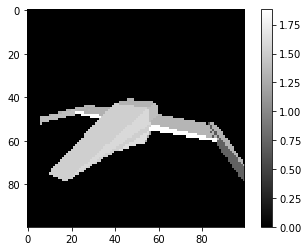

In [96]:
screen=np.zeros((screen_height,screen_width))
for i in range(screen_height):
    for j in range(screen_width):
        screen[i][j]=screen_transmission_buffer[i*screen_width+j]
print(screen)
import matplotlib.pyplot as plt
plt.imshow(screen,cmap='gray')
plt.colorbar()
plt.show()